In [371]:
%load_ext autoreload
%autoreload 2

In [490]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from imblearn.under_sampling import NearMiss
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve, auc

def plot_learning_curve(model, chart_title, features, targets, score_limits=None, cross_val_method=None, n_jobs=None, data_points=np.linspace(0.1, 1.0, 5)):
 
    plt.figure(figsize=(8, 6))
    plt.title(chart_title)
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy")
    if score_limits is not None:
        plt.ylim(score_limits)
    
    sample_sizes, training_scores, test_scores = learning_curve(
        model, features, targets, cv=cross_val_method, n_jobs=n_jobs, train_sizes=data_points
    )

    mean_training_scores = np.mean(training_scores, axis=1)
    std_training_scores = np.std(training_scores, axis=1)
    mean_test_scores = np.mean(test_scores, axis=1)
    std_test_scores = np.std(test_scores, axis=1)
    

    plt.grid(True, linestyle='--')
    plt.fill_between(sample_sizes, mean_training_scores - std_training_scores, mean_training_scores + std_training_scores, alpha=0.1, color="#FFA07A")
    plt.fill_between(sample_sizes, mean_test_scores - std_test_scores, mean_test_scores + std_test_scores, alpha=0.1, color="#20B2AA")
    plt.plot(sample_sizes, mean_training_scores, 'o-', color="#FF6347", label="Training Accuracy")
    plt.plot(sample_sizes, mean_test_scores, 'o-', color="#3CB371", label="test Accuracy")
    
    plt.legend(loc="lower right")
    plt.show()
    return plt

def plot_validation_curve(data_features, data_target, classifier, model_type): 
    if model_type == 'svm':
        hyperparameter_values = [0.01, 0.1, 1.0, 10.0, 70,100.0]
        hyperparameter = 'C'
    elif model_type == 'decision tree':
        hyperparameter_values = np.arange(1, 20)
        hyperparameter = 'max_depth'
    elif model_type == 'knn':
        hyperparameter_values = np.arange(1, 20)
        hyperparameter = 'n_neighbors'
    elif model_type == 'neural network':
        hyperparameter_values = [1e-03, 1e-02, 1e-01, 1]
        hyperparameter = 'alpha'
    elif model_type == 'boosted decision tree':
        hyperparameter_values = np.arange(10, 200,15)
        hyperparameter = 'n_estimators'

    train_scores, val_scores = validation_curve(
        classifier, data_features, data_target, 
        param_name=hyperparameter, param_range=hyperparameter_values, 
        cv=5, scoring="accuracy", n_jobs=1
    )

    mean_train_scores = np.mean(train_scores, axis=1)
    std_train_scores = np.std(train_scores, axis=1)
    mean_val_scores = np.mean(val_scores, axis=1)
    std_val_scores = np.std(val_scores, axis=1)

    plt.title("Breast Validation Curve for " + model_type)
    plt.xlabel(hyperparameter)
    plt.ylabel("Accuracy")
    plt.ylim(0.0, 1.1)
    plt.grid(True)
    line_width = 2
    plt.plot(hyperparameter_values, mean_train_scores, 'o-', color="red", lw=line_width, label="Training Accuracy")
    plt.fill_between(hyperparameter_values, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, color="red", alpha=0.2, lw=line_width)
    plt.plot(hyperparameter_values, mean_val_scores, 's-', color="blue", lw=line_width, label="Cross-validation Accuracy")
    plt.fill_between(hyperparameter_values, mean_val_scores - std_val_scores, mean_val_scores + std_val_scores, color="blue", alpha=0.2, lw=line_width)
    plt.legend(loc="lower right")
    plt.show()


In [373]:
n_cpu = os.cpu_count()
n_thread = n_cpu*2

In [374]:
df = pd.read_csv("/Users/davis901/Desktop/GT/Supervised_Learning/CS7641/data/Breast_Cancer.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4024 non-null   int64 
 1   Race                    4024 non-null   object
 2   Marital Status          4024 non-null   object
 3   T Stage                 4024 non-null   object
 4   N Stage                 4024 non-null   object
 5   6th Stage               4024 non-null   object
 6   differentiate           4024 non-null   object
 7   Grade                   4024 non-null   object
 8   A Stage                 4024 non-null   object
 9   Tumor Size              4024 non-null   int64 
 10  Estrogen Status         4024 non-null   object
 11  Progesterone Status     4024 non-null   object
 12  Regional Node Examined  4024 non-null   int64 
 13  Reginol Node Positive   4024 non-null   int64 
 14  Survival Months         4024 non-null   int64 
 15  Stat

In [419]:
df['Status'].value_counts()

Alive    3408
Dead      616
Name: Status, dtype: int64

In [376]:
df.describe()

,Age,Tumor Size,Regional Node Examined,Reginol Node Positive,Survival Months
count,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000
mean,53.972167,30.473658,14.357107,4.158052,71.297962
std,8.963134,21.119696,8.099675,5.109331,22.921430
min,30.000000,1.000000,1.000000,1.000000,1.000000
25%,47.000000,16.000000,9.000000,1.000000,56.000000
50%,54.000000,25.000000,14.000000,2.000000,73.000000
75%,61.000000,38.000000,19.000000,5.000000,90.000000
max,69.000000,140.000000,61.000000,46.000000,107.000000


/var/folders/_4/67t44wh97g164tfsk_37l_tm0000gn/T/ipykernel_11176/901736822.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


<Axes: >

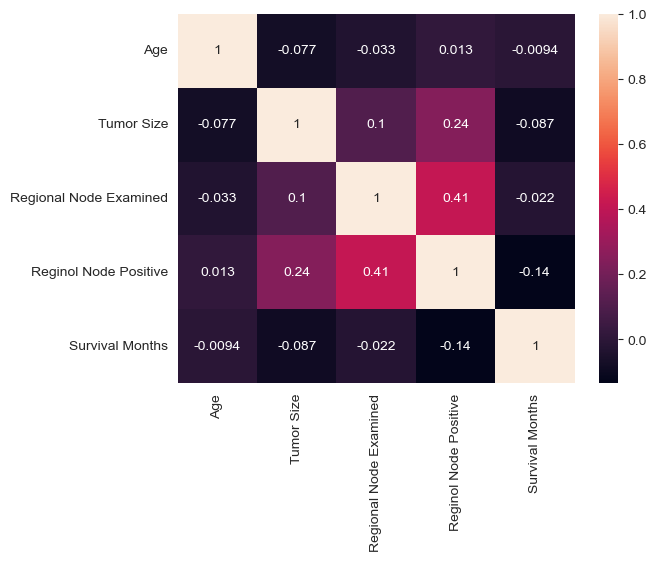

In [377]:
sns.heatmap(df.corr(), annot=True)

<Axes: xlabel='Age', ylabel='Count'>

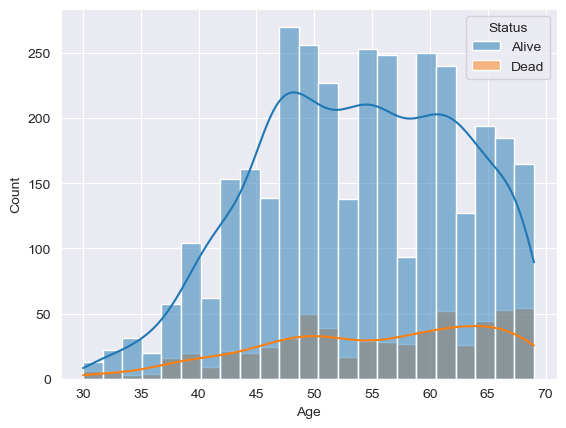

In [378]:
sns.histplot(data=df, x='Age', hue='Status', kde=True)

<Axes: xlabel='Tumor Size', ylabel='Count'>

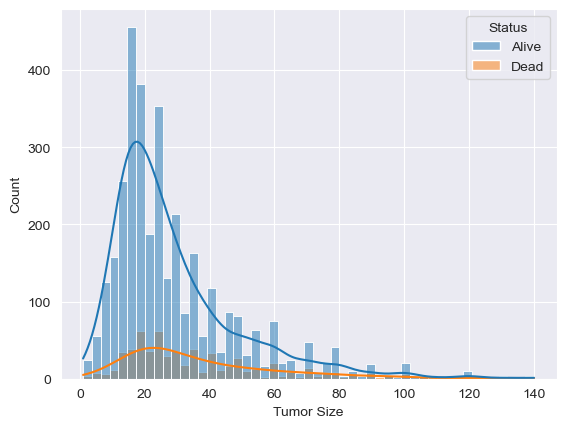

In [379]:
sns.histplot(data=df, x='Tumor Size', hue='Status', kde=True)

In [380]:
df.columns

Index(['Age', 'Race', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage',
       'differentiate', 'Grade', 'A Stage', 'Tumor Size', 'Estrogen Status',
       'Progesterone Status', 'Regional Node Examined',
       'Reginol Node Positive', 'Survival Months', 'Status'],
      dtype='object')

In [381]:
X_num = df[['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive']]
X_cat = df.drop(['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive', 'Status'], axis=1)
y = df['Status']

In [418]:
y.value_counts()

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

In [382]:
le = LabelEncoder()
y = le.fit_transform(y)
for col in X_cat.columns:
  X_cat[col] = le.fit_transform(X_cat[col])

In [383]:
X = pd.concat([X_num, X_cat], axis=1)
X.head()

,Age,Tumor Size,Regional Node Examined,Reginol Node Positive,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Estrogen Status,Progesterone Status,Survival Months
0,68,4,24,1,2,1,0,0,0,1,3,1,1,1,59
1,50,35,14,5,2,1,1,1,2,0,2,1,1,1,61
2,58,63,14,7,2,0,2,2,4,0,2,1,1,1,74
3,58,18,2,1,2,1,0,0,0,1,3,1,1,1,83
4,47,41,3,1,2,1,1,0,1,1,3,1,1,1,49


AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

In [384]:
# scaler = StandardScaler()
# scaler.fit(X_num)
# X_scaled = scaler.transform(X_num)
# X_scaled = pd.DataFrame(X_scaled, index=X_num.index, columns=X_num.columns)
# X_scaled = pd.concat([X_scaled, X_cat], axis=1)
# y_scaled = y
nm=NearMiss()
X_scaled, y_scaled = nm.fit_resample(X, y)
# X_scaled, y_scaled = nm.fit_resample(X_scaled, y_scaled)
X_scaled.count()

Age                       1232
Tumor Size                1232
Regional Node Examined    1232
Reginol Node Positive     1232
Race                      1232
Marital Status            1232
T Stage                   1232
N Stage                   1232
6th Stage                 1232
differentiate             1232
Grade                     1232
A Stage                   1232
Estrogen Status           1232
Progesterone Status       1232
Survival Months           1232
dtype: int64

In [385]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.25, random_state=1)

In [416]:
X_train.shape, y_test.shape

((924, 15), (308,))

# Decision Tree

In [387]:
model_dt = DecisionTreeClassifier()
param_dt = {
    'criterion':['gini','entropy'],
    'min_samples_split':[2,5,10,15],
    'max_depth':[None, 1,3,5, 7 ,9],
    'min_samples_leaf':[None, 1,3,10,15],
    'max_features':[None,'sqrt','log2']
}

In [388]:
GSDT1 = GridSearchCV(model_dt, param_dt, cv=5, scoring='accuracy', n_jobs=n_thread)
GSDT1.fit(X_train, y_train)
print('best_param:', GSDT1.best_params_)
print('best_score:', GSDT1.best_score_)

best_param: {'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
best_score: 0.8517097532314925


/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
720 fits failed out of a total of 3600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
720 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/Users/davis901

In [389]:
pred_dt = GSDT1.predict(X_test)
print(classification_report(y_test, pred_dt))

              precision    recall  f1-score   support

           0       0.78      0.94      0.85       159
           1       0.91      0.71      0.80       149

    accuracy                           0.83       308
   macro avg       0.84      0.82      0.82       308
weighted avg       0.84      0.83      0.83       308


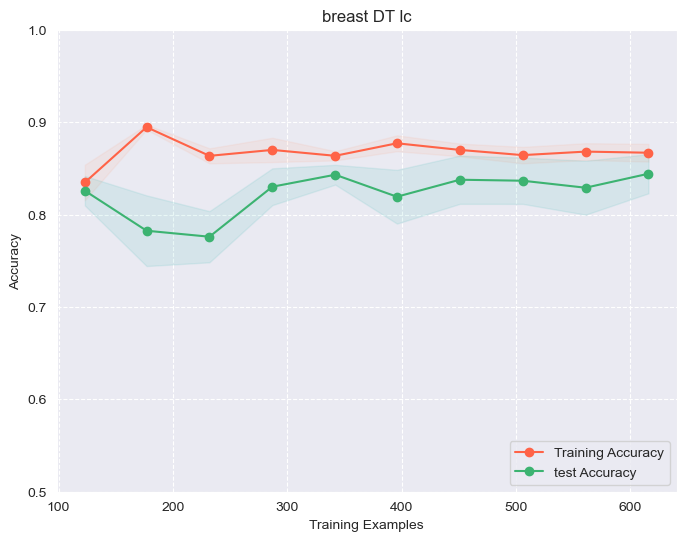

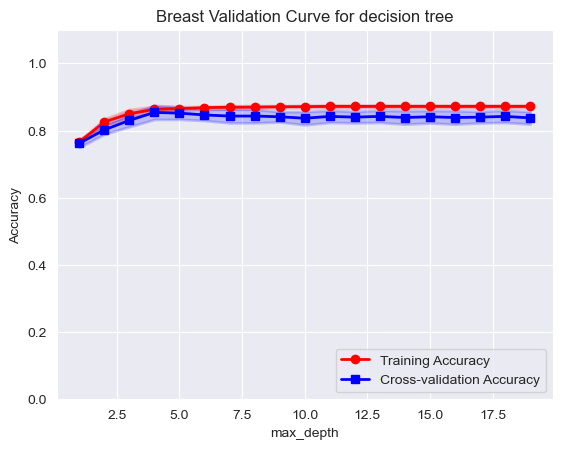

In [390]:

plot_learning_curve(GSDT1.best_estimator_, "breast DT lc", X_train, y_train, score_limits=(0.5,1.0), cross_val_method=3, n_jobs=n_thread, data_points=np.linspace(0.2,1.0,10))
plot_validation_curve(X_train, y_train, GSDT1.best_estimator_, "decision tree")

# SVM


In [495]:
model_svm = LinearSVC()
param_svm = {
    'penalty': ['l1', 'l2'],  
    'loss': ['hinge', 'squared_hinge'],  
    'C': [0.01, 0.1, 1, 10,70,100],  
}

In [496]:
GSSVM1 = GridSearchCV(model_svm, param_svm, cv=5, scoring='accuracy', n_jobs=n_thread)
GSSVM1.fit(X_train, y_train)
print('best_param:', GSSVM1.best_params_)
print('best_score:', GSSVM1.best_score_)

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244

best_param: {'C': 0.01, 'loss': 'hinge', 'penalty': 'l2'}
best_score: 0.7964864864864866


/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244

In [497]:
pred_svm = GSSVM1.predict(X_test)
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.74      0.92      0.82       159
           1       0.88      0.65      0.75       149

    accuracy                           0.79       308
   macro avg       0.81      0.78      0.78       308
weighted avg       0.81      0.79      0.78       308


/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244

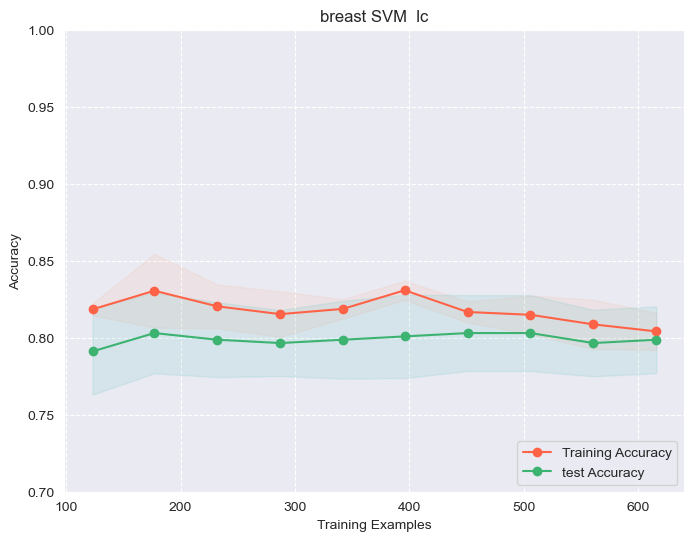

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244

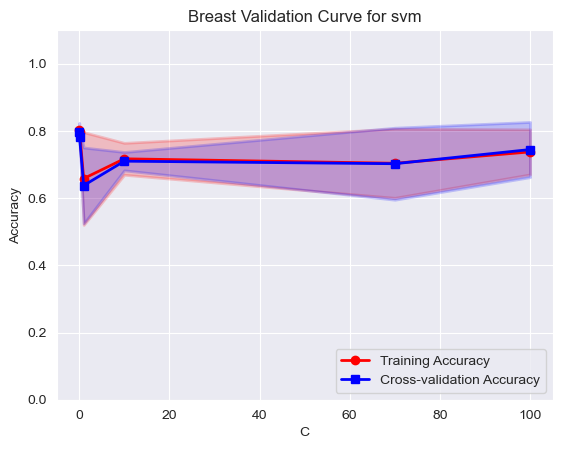

In [498]:
plot_learning_curve(GSSVM1.best_estimator_, "breast SVM  lc", X_train, y_train, score_limits=(0.7,1.0), cross_val_method=3, n_jobs=n_thread, data_points=np.linspace(0.2,1.0,10))
plot_validation_curve(X_train, y_train, GSSVM1.best_estimator_, "svm")

In [512]:
model_svc = SVC()
param_svc = {
    'C': [0.01, 0.1, 1, 10, 70,100],  
    'gamma': [0.001,0.01, 0.1, 1, 10,100],  
    'kernel': ['rbf'],
 
    'max_iter': [500, 1000, 2000]
}

In [513]:
GSSVM2 = GridSearchCV(model_svc, param_svc, cv=5, scoring='accuracy', n_jobs=n_thread)
GSSVM2.fit(X_train, y_train)
print('best_param:', GSSVM2.best_params_)
print('best_score:', GSSVM2.best_score_)

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299:

best_param: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf', 'max_iter': 500}
best_score: 0.8441186839012926


/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [514]:
pred_svm2 = GSSVM2.predict(X_test)
print(classification_report(y_test, pred_svm2))

              precision    recall  f1-score   support

           0       0.79      0.96      0.87       159
           1       0.95      0.72      0.82       149

    accuracy                           0.85       308
   macro avg       0.87      0.84      0.84       308
weighted avg       0.87      0.85      0.84       308


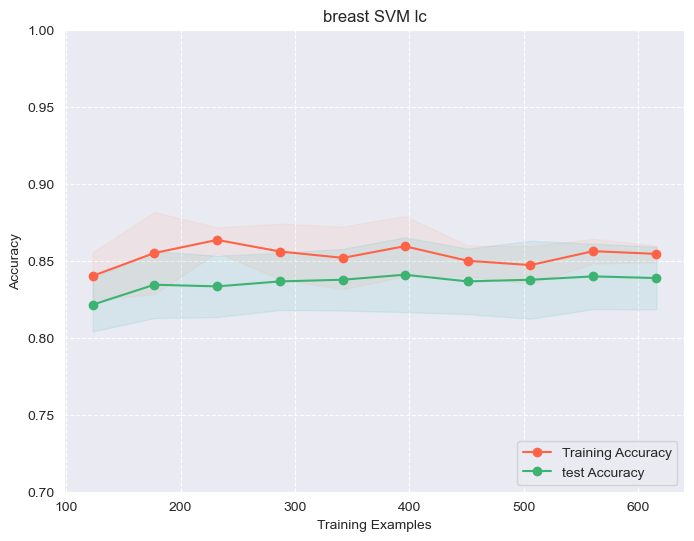

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299:

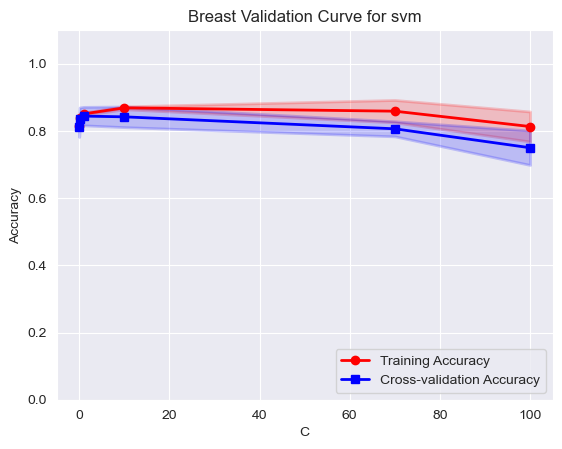

In [515]:
plot_learning_curve(GSSVM2.best_estimator_, "breast SVM lc", X_train, y_train, score_limits=(0.7,1.0), cross_val_method=3, n_jobs=n_thread, data_points=np.linspace(0.2,1.0,10))
plot_validation_curve(X_train, y_train, GSSVM2.best_estimator_, "svm")

# KNN

In [522]:
model_knn = KNeighborsClassifier()
param_knn = {
    'n_neighbors': [1,2, 3, 4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20],  
    'weights': ['uniform', 'distance'],  
    'algorithm': ['auto'],  
    
}

In [523]:
GSKNN1 = GridSearchCV(model_knn, param_knn, cv=5, scoring='accuracy', n_jobs=n_thread)
GSKNN1.fit(X_train, y_train)
print('best_param:', GSKNN1.best_params_)
print('best_score:', GSKNN1.best_score_)

best_param: {'algorithm': 'auto', 'n_neighbors': 16, 'weights': 'distance'}
best_score: 0.8213983548766158


In [524]:
pred_knn = GSKNN1.predict(X_test)
print(classification_report(y_test, pred_knn))

              precision    recall  f1-score   support

           0       0.74      0.97      0.84       159
           1       0.95      0.64      0.77       149

    accuracy                           0.81       308
   macro avg       0.85      0.81      0.80       308
weighted avg       0.84      0.81      0.81       308


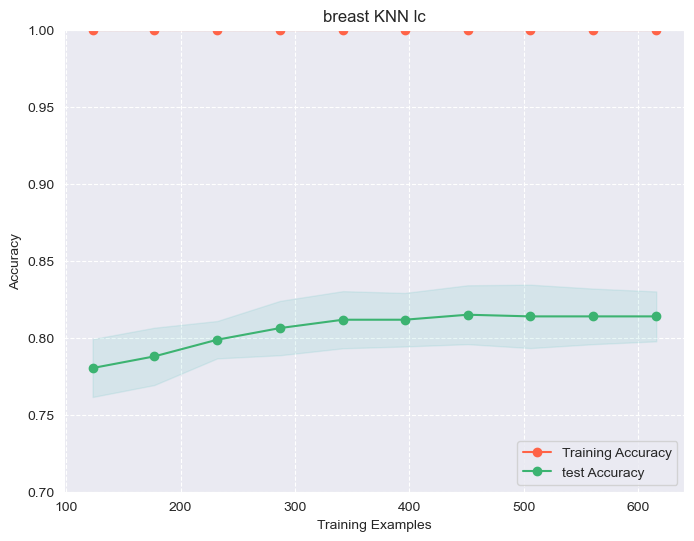

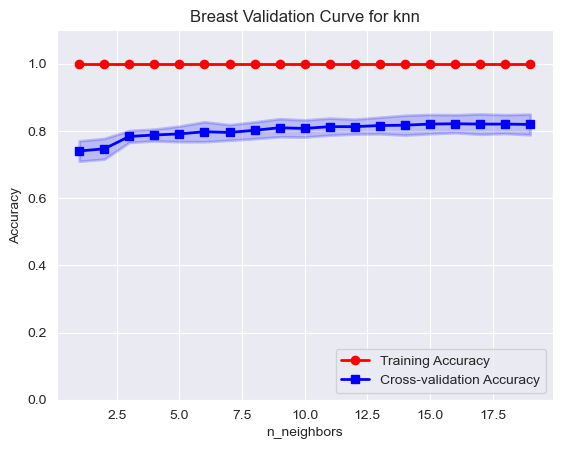

In [525]:
plot_learning_curve(GSKNN1.best_estimator_, "breast KNN lc", X_train, y_train, score_limits=(0.7,1.0), cross_val_method=3, n_jobs=n_thread, data_points=np.linspace(0.2,1.0,10))
plot_validation_curve(X_train, y_train, GSKNN1.best_estimator_, "knn")

# Neural Net

In [405]:
model_nn = MLPClassifier(max_iter=7000, learning_rate='adaptive')
param_nn = {
	'alpha': [1e-05,1e-04,1e-03,1e-02,1e-01,1,2,3],
	'learning_rate_init': [0.001,0.01,0.1,1],
	'activation': ['tanh', 'relu']
}

In [406]:
GSNN = GridSearchCV(model_nn, param_nn, cv=5, scoring='accuracy', n_jobs=n_thread)
GSNN.fit(X_train, y_train)
print('best_param:', GSNN.best_params_)
print('best_score:', GSNN.best_score_)

best_param: {'activation': 'relu', 'alpha': 2, 'learning_rate_init': 0.001}
best_score: 0.8408813160987074


In [407]:
pred_nn = GSNN.predict(X_test)
print(classification_report(y_test, pred_nn))

              precision    recall  f1-score   support

           0       0.80      0.92      0.86       159
           1       0.90      0.76      0.82       149

    accuracy                           0.84       308
   macro avg       0.85      0.84      0.84       308
weighted avg       0.85      0.84      0.84       308


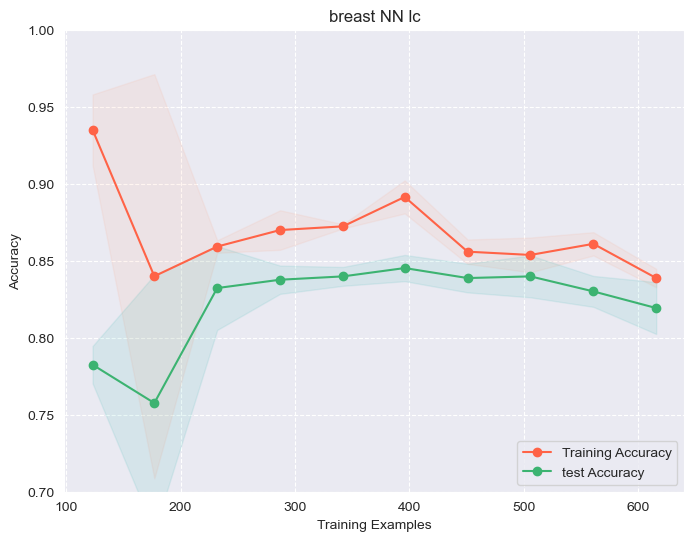

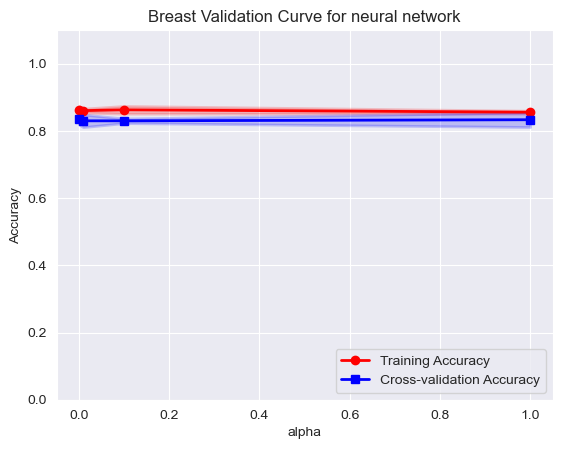

In [408]:
plot_learning_curve(GSNN.best_estimator_, "breast NN lc", X_train, y_train, score_limits=(0.7,1.0), cross_val_method=3, n_jobs=n_thread, data_points=np.linspace(0.2,1.0,10))
plot_validation_curve(X_train, y_train, GSNN.best_estimator_, "neural network")

#  Boosted Decision Tree

In [480]:
model_bdt = AdaBoostClassifier()
best_est_dt = DecisionTreeClassifier(criterion='gini', max_depth=4, max_features=None, min_samples_leaf=30, min_samples_split= 30)
param_bdt = {
	'base_estimator': [GSDT1.best_estimator_, best_est_dt],
     'n_estimators': [50,70,90,110,130,150,170,190,200],  
    'learning_rate': [0.0001,0.001,0.01, 0.1, 1.0],  

}

In [481]:
GSBDT = GridSearchCV(model_bdt, param_bdt, cv=5, scoring='accuracy', n_jobs=n_thread)
GSBDT.fit(X_train, y_train)
print('best_param:', GSBDT.best_params_)
print('best_score:', GSBDT.best_score_)

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed 

best_param: {'base_estimator': DecisionTreeClassifier(max_depth=4, min_samples_leaf=30, min_samples_split=30), 'learning_rate': 0.01, 'n_estimators': 70}
best_score: 0.858202115158637


/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [482]:
pred_bdt = GSBDT.predict(X_test)
print(classification_report(y_test, pred_bdt))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87       159
           1       0.92      0.76      0.83       149

    accuracy                           0.85       308
   macro avg       0.86      0.85      0.85       308
weighted avg       0.86      0.85      0.85       308


/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed 

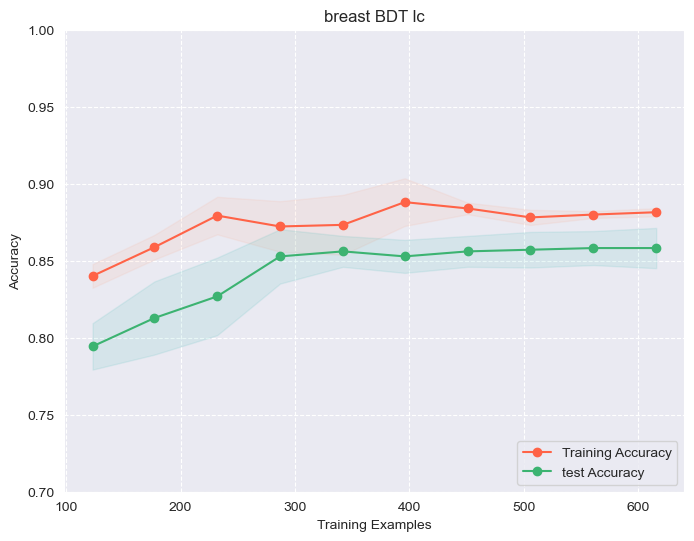

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed 

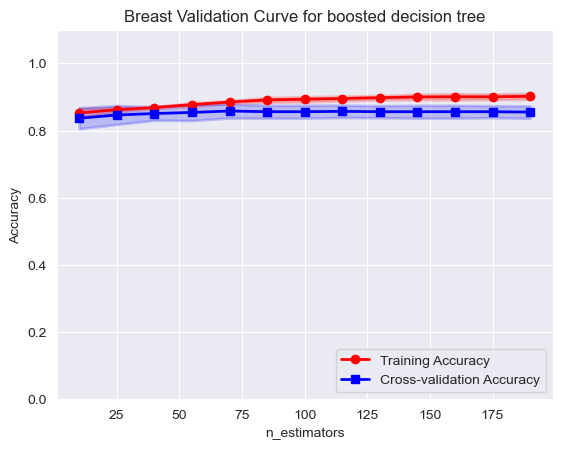

In [483]:
plot_learning_curve(GSBDT.best_estimator_, "breast BDT lc", X_train, y_train, score_limits=(0.7,1.0), cross_val_method=3, n_jobs=n_thread, data_points=np.linspace(0.2,1.0,10))
plot_validation_curve(X_train, y_train, GSBDT.best_estimator_, "boosted decision tree")

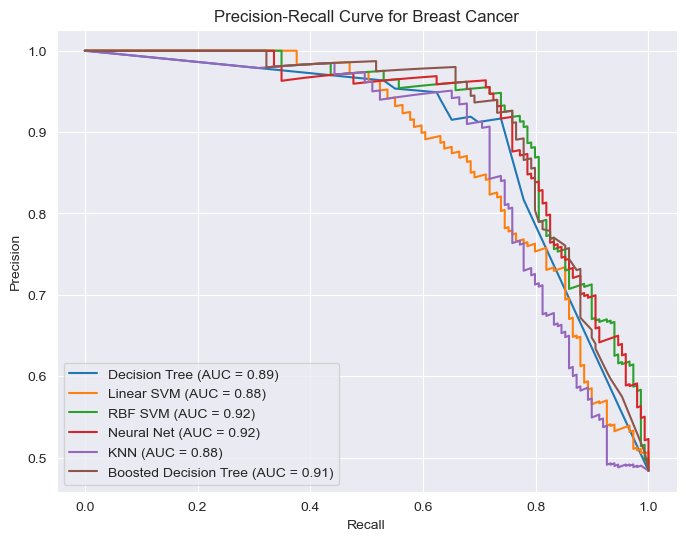

In [527]:
# Assuming GSRL1, GSDT1, GSRF1, and GS_LGB1 are your trained GridSearchCV objects for different models
models = [
    ('Decision Tree', GSDT1.best_estimator_),
    ('Linear SVM', GSSVM1.best_estimator_),
    ('RBF SVM', GSSVM2.best_estimator_),
    ('Neural Net', GSNN.best_estimator_),
    ('KNN', GSKNN1.best_estimator_),
    ('Boosted Decision Tree', GSBDT.best_estimator_)
]

fig = plt.figure(figsize=(8, 6))
ax = fig.gca()

for name, model in models:
    if hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        y_scores = model.predict_proba(X_test)[:, 1]
    
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(recall, precision)
    
    ax.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.2f})')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve for Breast Cancer')
ax.legend(loc='best')
plt.show()